## PyOpenCl

### Предварительная настройка
Установка необходимых библиотек и расширений для работы openCL

In [ ]:
!pip install pyopencl[pocl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 5.3 MB/s eta 0:00:00


In [ ]:
%load_ext pyopencl.ipython_ext

### Пример работы
Демонстрация работы pyOpenCL в Google Colab, вывод информации о платформе и устройствах

In [ ]:
from __future__ import division
import numpy as np
import pyopencl as cl
import pyopencl.array

ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)


def print_device_info() :
    print('\n' + '=' * 60 + '\nOpenCL Платформы и устройства')
    for platform in cl.get_platforms():
        print('=' * 60)
        print('Платформа - Имя: ' + platform.name)
        print('Платформа - Производитель: ' + platform.vendor)
        print('Платформа - Версия: ' + platform.version)
        print('Платформа - Профиль: ' + platform.profile)

        for device in platform.get_devices():
            print(' ' + '-' * 56)
            print(' Устройство - Имя: ' \
                  + device.name)
            print(' Устройство - Тип: ' \
                  + cl.device_type.to_string(device.type))
            print(' Устройство - Макисмальная частота: {0} Мгц'\
                  .format(device.max_clock_frequency))
            print(' Устройство - Вычислительных блоков: {0}'\
                  .format(device.max_compute_units))
            print(' Устройство - Локальная память: {0:.0f} КБ'\
                  .format(device.local_mem_size/1024.0))
            print(' Устройство - Постоянной памяти: {0:.0f} КБ'\
                  .format(device.max_constant_buffer_size/1024.0))
            print(' Устройство - Глобальной памяти: {0:.0f} ГБ'\
                  .format(device.global_mem_size/1073741824.0))
            print(' Устройство - Максимальный Буфер/Размер изображения: {0:.0f} МБ'\
                  .format(device.max_mem_alloc_size/1048576.0))
            print(' Устройство - Max Work Group Size: {0:.0f}'\
                  .format(device.max_work_group_size))
    print('\n')


print_device_info()

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7dd18bf88d00>
Choice [0]:0
Set the environment variable PYOPENCL_CTX='0' to avoid being asked again.

OpenCL Платформы и устройства
Платформа - Имя: Portable Computing Language
Платформа - Производитель: The pocl project
Платформа - Версия: OpenCL 3.0 PoCL 3.0-rc2  Linux, Release, RELOC, LLVM 14.0.6, SLEEF, DISTRO, POCL_DEBUG
Платформа - Профиль: FULL_PROFILE
 --------------------------------------------------------
 Устройство - Имя: pthread-Intel(R) Xeon(R) CPU @ 2.20GHz
 Устройство - Тип: ALL | CPU
 Устройство - Макисмальная частота: 2200 Мгц
 Устройство - Вычислительных блоков: 2
 Устройство - Локальная память: 512 КБ
 Устройство - Постоянной памяти: 512 КБ
 Устройство - Глобальной памяти: 11 ГБ
 Устройство - Максимальный Буфер/Размер изображения: 4096 МБ
 Устройство - Max Work Group Size: 4096




### №9
Создать программу для решения простых дифференциальных уравнений с помощью функции ядра, используйте метод Эйлера или метод Рунге-Кутты .

In [ ]:
import pyopencl as cl
import numpy as np

t0 = 0.0  # начальное значние
y0 = 1.0  # начальное значение y
h = 0.01  # шаг интегрирования
num_steps = 1000  # количество шагов

context = cl.create_some_context()
queue = cl.CommandQueue(context)

y = np.zeros(num_steps + 1).astype(np.float32)
y[0] = y0

buffer = cl.mem_flags
buffer_y = cl.Buffer(context, buffer.READ_WRITE | buffer.COPY_HOST_PTR, hostbuf=y)

#( \frac{dy}{dt} = -2y ) Рунге-кутта
kernel_code = """
__kernel void Runga_Kutta(
    __global float* y,
    const int num_steps,
    const float t0,
    const float h){
      float k1,k2,k3,k4;
      float yi = y[0];
      float t = t0;

      for (int i = 0; i < num_steps; ++i){
        k1 = h * (-2.0f * yi);
        k2 = h * (-2.0f * (yi + k1 / 2.0f));
        k3 = h * (-2.0f * (yi + k2 / 2.0f));
        k4 = h * (-2.0f * (yi + k3));

        yi = yi + (k1 + 2.0f * k2 + 2.0f * k3 + k4) / 6.0f;
        y[i+1] = yi;
        t = t + h;
      }
}
"""

program = cl.Program(context,kernel_code).build()
Runge_Kutta_kernel = program.Runga_Kutta
Runge_Kutta_kernel.set_args(buffer_y,np.int32(num_steps),np.float32(t0),np.float32(h))

global_size=(num_steps,)
cl.enqueue_nd_range_kernel(queue,Runge_Kutta_kernel,global_size,None).wait()

cl.enqueue_copy(queue,y,buffer_y).wait()

print("Результат решения простого дифференциального уравнения методом Рунге-Кутты:")
for i in range(10):
    print(f"y({t0 +i*h}) = {y[i]}")

Результат решения простого дифференциального уравнения методом Рунге-Кутты:
y(0.0) = 1.0
y(0.01) = 0.9801986813545227
y(0.02) = 0.9607894420623779
y(0.03) = 0.9417645335197449
y(0.04) = 0.9231163263320923
y(0.05) = 0.9048373699188232
y(0.06) = 0.8869203925132751
y(0.07) = 0.8693581819534302
y(0.08) = 0.8521437644958496
y(0.09) = 0.8352701663970947


### №10
Создать программу для приближенного вычисления числа Пи с помощью функции ядра, используйте метод Монте-Карло.

In [ ]:
import numpy as np
import pyopencl as cl

context = cl.create_some_context()
queue = cl.CommandQueue(context)

limit_Nmax = 1e7  # Ограничение количества точек
limit_a = 1e6  # Ограничение радиуса круга
Pi = 0.0
a = 100  # радиус круга
kernel_code = """
  __kernel void monte_carlo(
    const int num_points,
    __global const float* random_x,
    __global const float* random_y,
    __global int* count){
      int i = get_global_id(0);
      if (i >= num_points)
        return;

      float x = random_x[i];
      float y = random_y[i];
      if (x * x + y * y <= 1.0f)
        atomic_add(count, 1);
  }"""

while a < limit_a:
  Nmax = a
  while Nmax <= limit_Nmax:
    num_points = int(Nmax)

    random_x = np.random.rand(num_points).astype(np.float32)
    random_y = np.random.rand(num_points).astype(np.float32)
    count = np.zeros(1).astype(np.int32)

    buffer = cl.mem_flags
    random_x_buf = cl.Buffer(context, buffer.READ_ONLY | buffer.COPY_HOST_PTR, hostbuf=random_x)
    random_y_buf = cl.Buffer(context, buffer.READ_ONLY | buffer.COPY_HOST_PTR, hostbuf=random_y)
    count_buf = cl.Buffer(context, buffer.READ_WRITE | buffer.COPY_HOST_PTR, hostbuf=count)

    program = cl.Program(context, kernel_code).build()
    monte_carlo_kernel = program.monte_carlo
    monte_carlo_kernel.set_args(np.int32(num_points), random_x_buf, random_y_buf, count_buf)

    global_size = (num_points,)
    cl.enqueue_nd_range_kernel(queue, monte_carlo_kernel, global_size, None).wait()
    cl.enqueue_copy(queue, count, count_buf).wait()

    Nmax *= 2
    a *= 2

Pi = 4.0 * count[0] / num_points
print(f"Pi: {Pi}")

Pi: 3.1413519287109377


### №11 **(Фракталы)**
Реализовать с использованием функций ядра в PyOpenCL фракталы:
* множество Бернса-Шиппена

#### **Пример** с фракталом Мандельброта

In [ ]:
import time
import numpy as np
import pyopencl as cl
from PIL import Image


def calc_fractal_opencl(q, maxiter):
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)

  output = np.empty(q.shape, dtype=np.uint16)
  mf = cl.mem_flags
  q_opencl = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=q)
  output_opencl = cl.Buffer(ctx, mf.WRITE_ONLY, output.nbytes)

  prg = cl.Program(
      ctx,
      """
  #pragma OPENCL EXTENSION cl_khr_byte_addressable_store : enable
  __kernel void mandelbrot(__global float2 *q,
                           __global ushort *output,
                           ushort const maxiter){
      int gid = get_global_id(0);
      float nreal, real = 0;
      float imag = 0;
      output[gid] = 0;
      for(int curiter = 0; curiter < maxiter; curiter++){
        nreal = real*real - imag*imag + q[gid].x;
        imag = 2* real*imag + q[gid].y;
        real = nreal;

        if (real*real + imag*imag > 4.0f){
          output[gid] = curiter;
          break;
        }
      }
  }""",).build()

  prg.mandelbrot(queue, output.shape, None, q_opencl, output_opencl, np.uint16(maxiter))
  cl.enqueue_copy(queue, output, output_opencl).wait()
  return output

##### Просто Python

In [ ]:
def calc_fractal_serial(q, maxiter):
  z = np.zeros(q.shape, complex)
  output = np.resize(
      np.array(0,),
      q.shape,
  )
  for i in range(len(q)):
    for iter in range(maxiter):
      z[i] = z[i] * z[i] + q[i]
      if abs(z[i]) > 2.0:
        output[i] = iter
        break
  return output

##### Через **NumPY**

In [ ]:
def calc_fractal_numpy(q, maxiter):
  output = np.resize(
      np.array(0,),
      q.shape,
  )
  z = np.zeros(q.shape, np.complex64)

  for it in range(maxiter):
    z = z * z + q
    done = np.greater(abs(z), 2.0)
    q = np.where(done, 0 + 0j, q)
    z = np.where(done, 0 + 0j, z)
    output = np.where(done, it, output)
  return output

##### Отрисовка

Main took 0.12409305572509766


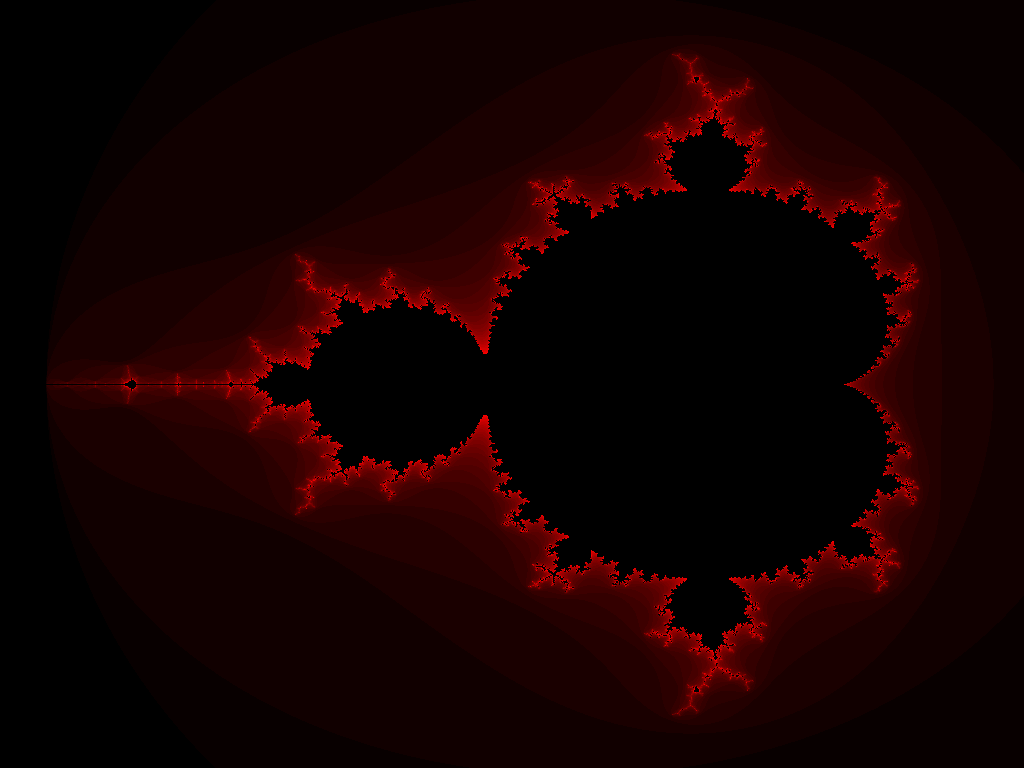

In [ ]:
WIDTH = 1024
HEIGHT = 768

def draw(x1, x2, y1, y2, maxiter=30):
  xx = np.arange(x1, x2, (x2 - x1) / WIDTH)
  yy = np.arange(y2, y1, (y1 - y2) / HEIGHT) * 1j
  q = np.ravel(xx + yy[:, np.newaxis]).astype(np.complex64)

  start_main = time.time()
  output = calc_fractal(q, maxiter)
  end_main = time.time()

  secs = end_main - start_main
  print("Main took", secs)

  mandel = (output.reshape((HEIGHT, WIDTH)) / float(output.max()) * 255.0).astype(
    np.uint8
  )
  return mandel


calc_fractal = calc_fractal_opencl  #  Можно выбрать иную реализацию вычислительной функции
pic = draw(-2.13, 0.77, -1.3, 1.3)
img = Image.fromarray(pic)
img.putpalette([i for rgb in ((j, 0, 0) for j in range(255)) for i in rgb])
display(img)

#### Множество Бернса-Шиппена

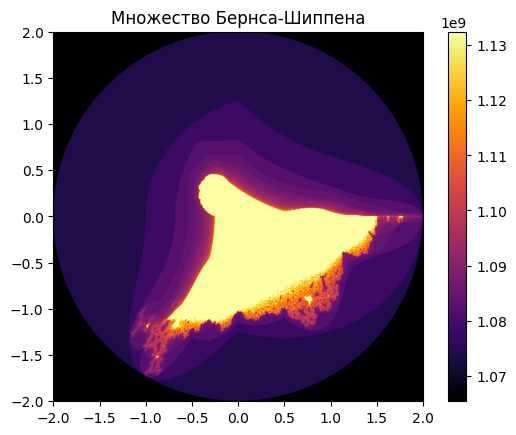

In [ ]:
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt

max_iters=256
w,h = 1024,768
xmin, xmax=-2,2
ymin, ymax=-2,2

kernel_code = """
__kernel void burning_ship(
    const int Nmax,
    __global float *res,
    __global float *xx,
    __global float *yy)
{
    int gid = get_global_id(0);
    float x = 0.0f;
    float y = 0.0f;
    float cx = xx[gid];
    float cy = yy[gid];
    int ii = 0;

    while (Nmax > ii && x * x + y * y < 4.0f){
        float x_new = fabs(x * x - y * y - cx);
        y = 2.0f * fabs(x * y) - cy;
        x = x_new;
        ii++;
    }
    res[gid] = ii;
}
"""

platform = cl.get_platforms()[0]
device = platform.get_devices()[0]
context = cl.Context([device])
queue = cl.CommandQueue(context)

program = cl.Program(context, kernel_code).build()
burning_ship_kernel = program.burning_ship

x = np.linspace(xmin, xmax, w).astype(np.float32)
y = np.linspace(ymin, ymax, h).astype(np.float32)
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()

x_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=x)
y_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=y)
res_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, x.nbytes)

res = np.empty_like(x, dtype=np.int32)

burning_ship_kernel.set_args(np.int32(max_iters), res_buf, x_buf, y_buf)
cl.enqueue_nd_range_kernel(queue, burning_ship_kernel, (x.size,), None).wait()

cl.enqueue_copy(queue, res, res_buf).wait()

res = res.reshape((h, w))
plt.imshow(res, extent=(xmin, xmax, ymin, ymax), cmap='inferno')
plt.colorbar()
plt.title("Множество Бернса-Шиппена")
plt.show()